# Random walks on the spanning cluster

In this notebook we'll explore diffusion on the spanning cluster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import tqdm
import sklearn.linear_model

from generate_spanning_cluster import get_spanning_cluster
from percwalk import percwalk
from log_binning import log_bin

In [2]:
sns.set(color_codes=True)

In [3]:
# Critical percolation probability
p_c = 0.59275

## Distance moved on the percolating cluster

We'll start by exploring diffusion on the percolating cluster for $p > p_c$. We'll measure the second moment of the average distance, $\langle R^2 \rangle$, as a function of the number of steps performed. Below we'll demonstrate what the diffusion on the percolating cluster looks like.

In [4]:
spanning_cluster = get_spanning_cluster(100, p_c)

Having created a system with a percolating cluster, we start by visualizing the spanning cluster.

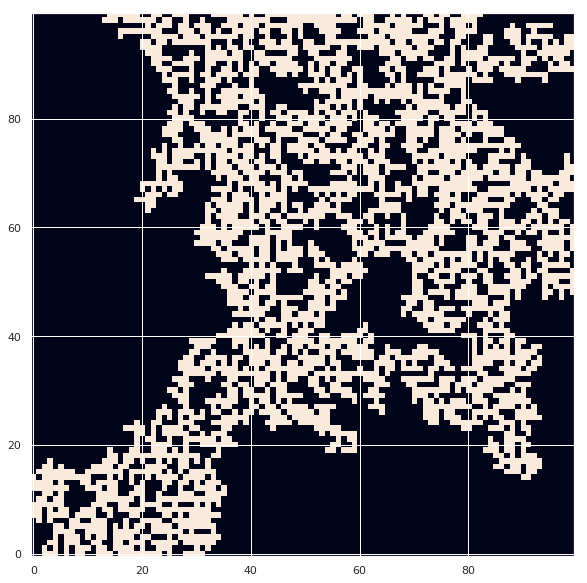

In [5]:
plt.figure(figsize=(14, 10))

plt.imshow(spanning_cluster, origin="lower")
plt.show()

Here we can see the sites contained in the percolating cluster. Moving on, we'll start a walker on a random site in the percolating cluster.

In [6]:
num_walks = int(1e5)
num_steps = 0

In [7]:
while num_steps <= 1:
    walker_map, displacements, num_steps = percwalk(spanning_cluster, num_walks)

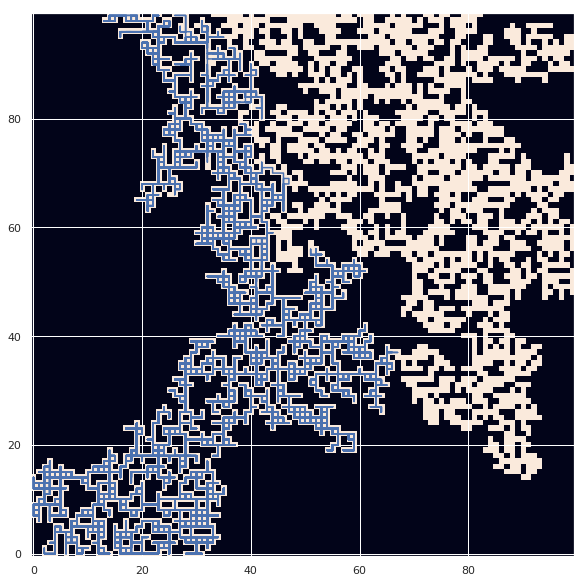

In [8]:
plt.figure(figsize=(14, 10))

plt.imshow(spanning_cluster, origin="lower")
# walker_map is oriented as row-column (ix, iy)
plt.plot(walker_map[1], walker_map[0])
plt.show()

In the above plot we can see how the walker moves in the spanning cluster. A thick line signifies several walks over a site.

## Mean squared distance

Next, we'll look at the mean squared distance, $\langle r^2 \rangle$, as a function of the number of walks, $N$, for varying $p > p_c$.
A free random walker behaves according to
\begin{align}
    \langle r^2 \rangle \propto D t,
\end{align}
as we've seen in the molecular dynamics simulations.
On the percolating cluster we expect that the random walker at times gets stuck in dangling ends or slows down through singly connected bonds.
This motivates the assumption that the diffusion will be slower on the percolating cluster and we expect the mean squared distance to go as
\begin{align}
    \langle r^2 \rangle \propto t^{2k},
\end{align}
where $k < 1/2$.
This is known as _subdiffusion_ as opposed to the _superdiffusion_ observed for the initial molecular dynamics simulations.

In [57]:
def get_squared_distance(L, p, num_walks, num_walkers, num_attempts=1000):
    spanning_cluster = get_spanning_cluster(L, p, num_attempts=num_attempts)
    displacements = np.zeros(num_walks)

    for walker in range(num_walkers):
        num_steps = 0

        while num_steps <= 1:
            walker_map, _displacements, num_steps = percwalk(spanning_cluster, num_walks)

        displacements += np.sum(_displacements ** 2, axis=0)

    return displacements

We now simulate a system of size $L$ and compute the mean squared displacement on the spanning cluster several times for every system.

In [61]:
L = 500
num_walks = int(1e5)
num_walks_arr = np.arange(num_walks)
p_arr = np.linspace(p_c, 0.7, 12)
num_walkers = 100
num_systems = 20

r_squared = np.zeros((len(p_arr), num_walks))

In [62]:
for system in tqdm.tqdm_notebook(range(num_systems)):
    for i, p in enumerate(p_arr):
        r_squared[i] += get_squared_distance(L, p, num_walks, num_walkers)

r_squared /= num_walkers

Having computed the mean squared displacment for several different values of $p \geq p_c$ we look at the diffusion behavior.
For $p = p_c$ we know that $\xi \to \infty$ and we know that
\begin{align}
    \langle r^2(t) \rangle \propto t^{2k},
\end{align}
for all values of $t$ as we will never have $\langle r^2(t) \rangle \gg \xi^2$.
We therefore estimate $k$ by taking the logarithm on both sides of the equation and using linear regression.
\begin{gather}
    \log\left( \langle r^2(t) \rangle \right)
    \propto 2k \log(t).
\end{gather}

In [63]:
log_walks = np.log(num_walks_arr[1:])
log_r = np.log(r_squared[0, 1:])

clf = sklearn.linear_model.LinearRegression().fit(
    log_walks[:, np.newaxis], log_r[:, np.newaxis]
)

k = clf.coef_[0, 0] / 2
C = clf.intercept_[0]

print(f"k = {k}")

k = 0.3506150589226773


Having found the intercept and the coefficient $k$ we plot $\langle r^2(t) \rangle$ as a function of the number of walks (time, in a sense) and compare it to the theoretical estimate.

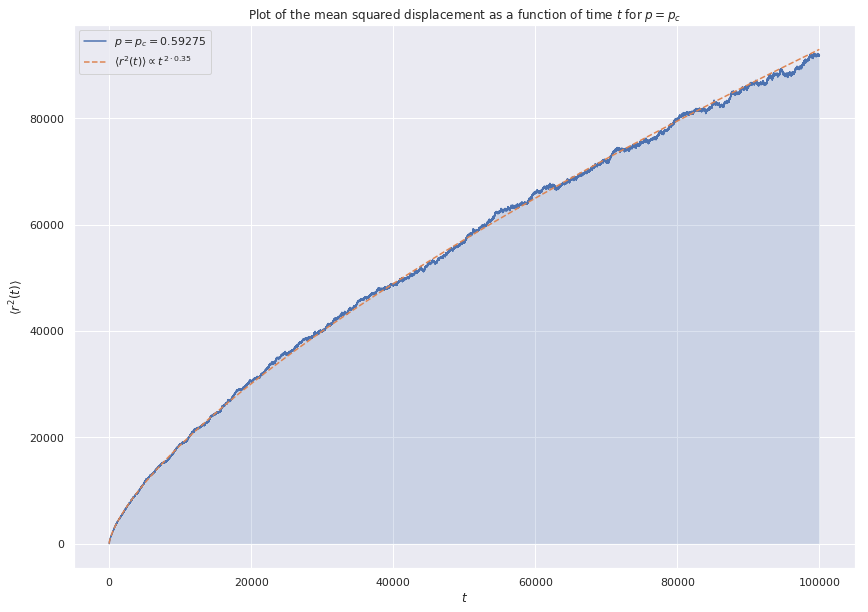

In [72]:
plt.figure(figsize=(14, 10))

plt.plot(
    num_walks_arr,
    r_squared[0],
    label=rf"$p = p_c = {p_c}$",
)
plt.fill_between(num_walks_arr, r_squared[0], alpha=0.2)

plt.plot(
    num_walks_arr,
    np.exp(C) * num_walks_arr ** (2 * k),
    "--",
    label=r"$\langle r^2(t) \rangle \propto t^{2 \cdot %.2f}$" % k,
)


plt.title(r"Plot of the mean squared displacement as a function of time $t$ for $p = p_c$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t) \rangle$")
plt.legend(loc="best")
plt.show()

In this figure we have plotted the mean squared displacement as a function of "time", i.e., the number of walks, on the spanning cluster for $p = p_c$. We observe the expected subdiffusion.
We also see how the theoretical estimate of the subdiffusion follows the data closely.

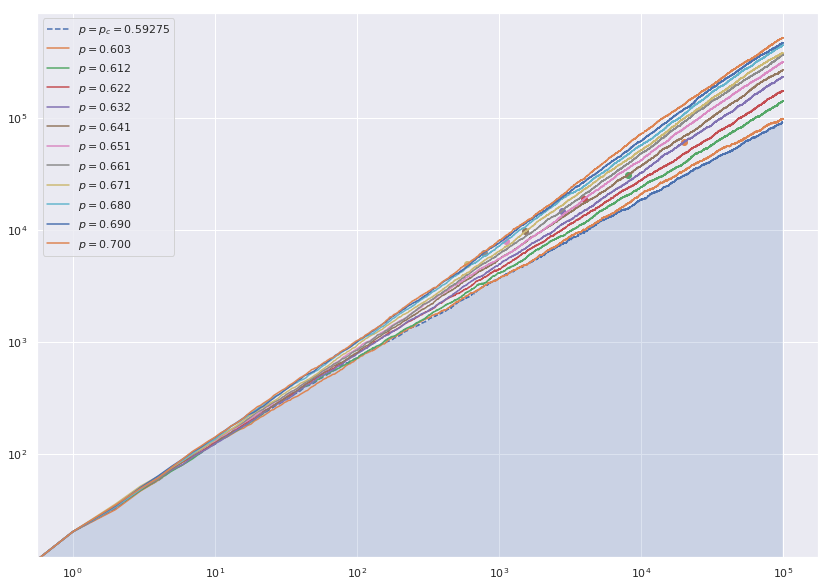

In [118]:
plt.figure(figsize=(14, 10))

plt.loglog(
    num_walks_arr,
    r_squared[0],
    "--",
    label=rf"$p = p_c = {p_c}$",
)
plt.fill_between(num_walks_arr, r_squared[0], alpha=0.2)

xi_squared_list = []
t_list = []
p_list = []

for i, p in enumerate(p_arr[1:]):
    plt.loglog(
        num_walks_arr,
        r_squared[i + 1],
        label=rf"$p = {p:.3f}$"
    )

    mask = r_squared[0, 1:] <= 0.5 * r_squared[i + 1, 1:]

    if not np.any(mask):
        continue

    index = np.argmax(mask)

    xi_squared_list.append(r_squared[i + 1, index])
    t_list.append(num_walks_arr[index])
    p_list.append(p)

    plt.scatter(num_walks_arr[index], r_squared[i + 1, index])

plt.legend(loc="best")
plt.show()

In [124]:
p_min_pc_arr = np.abs(np.array(p_list) - p_c)

clf = sklearn.linear_model.LinearRegression().fit(
    np.log(p_min_pc_arr)[:, np.newaxis], np.log(xi_squared_list)[:, np.newaxis],
)

mu = clf.coef_[0, 0] / 2
C = clf.intercept_[0]

print(f"mu = {mu}")

mu = -1.209447982092573


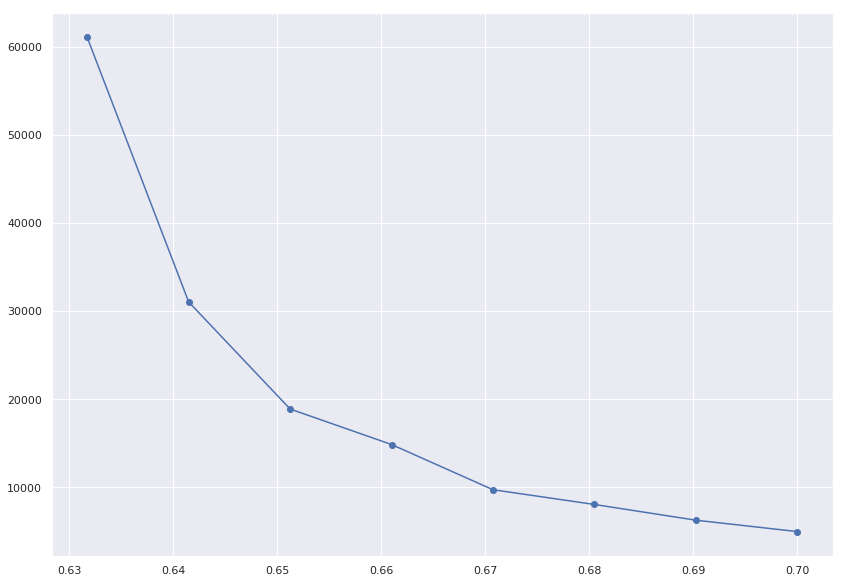

In [126]:
fig = plt.figure(figsize=(14, 10))

plt.plot(p_list, xi_squared_list, "-o")
plt.show()